#### Import modules

In [159]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

#### Import dataset

In [160]:
df = pd.read_csv('data/stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [161]:
df.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

#### X & y in dataframe

In [162]:
X = df.drop('math_score',axis=1)
y = df['math_score']
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (1000, 7)
Shape of y is (1000,)


#### Numerical and categorical variables in X

In [163]:
numerical_columns = X.select_dtypes(exclude='O').columns.tolist()
numerical_columns

['reading_score', 'writing_score']

In [164]:
categorical_columns_oneHotEnc = X.select_dtypes(include='O').columns.tolist() 
categorical_columns_oneHotEnc

['gender',
 'race_ethnicity',
 'parental_level_of_education',
 'lunch',
 'test_preparation_course']

In [165]:
categorical_columns_oneHotEnc.remove('parental_level_of_education')
categorical_columns_oneHotEnc

['gender', 'race_ethnicity', 'lunch', 'test_preparation_course']

#### One-Hot Encoding, Ordinal Encoding & Standard Scaling

In [166]:
categorical_columns_ordEnc = ['parental_level_of_education']

categories = [['some high school', 
            'high school',
            'some college',
            "associate's degree",
            "bachelor's degree",
            "master's degree"]]

# create pipeline for num and cat columns
num_pipeline = Pipeline(
steps = [
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
]
)

cat_pipeline_oneHotEnc = Pipeline(
steps = [
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("oneHotEnc",OneHotEncoder(sparse=False,drop="first")),
    ("scaler",StandardScaler(with_mean=False))
]
)

cat_pipeline_ordEnc = Pipeline(
steps = [
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("ordenc",OrdinalEncoder(categories=categories)),
    ("scaler",StandardScaler(with_mean=False))
]
)

# ColumnTransformer for above pipeline
preprocessor = ColumnTransformer(
[
    ("num_pipeline",num_pipeline,numerical_columns),
    ("cat_pipeline_oneHotEnc",cat_pipeline_oneHotEnc,categorical_columns_oneHotEnc),
    ("cat_pipeline_ordEnc",cat_pipeline_ordEnc,categorical_columns_ordEnc)
]
)


In [167]:
X_trans = preprocessor.fit_transform(X)

In [168]:
X_trans.shape

(1000, 10)

In [169]:
cat_var_trans =preprocessor.named_transformers_['cat_pipeline_oneHotEnc'].named_steps["oneHotEnc"].get_feature_names_out(categorical_columns_oneHotEnc)
cat_var_trans = cat_var_trans.tolist()
cat_var_trans

['gender_male',
 'race_ethnicity_group B',
 'race_ethnicity_group C',
 'race_ethnicity_group D',
 'race_ethnicity_group E',
 'lunch_standard',
 'test_preparation_course_none']

#### Getting mean & std for pipeline

In [170]:
preprocessor.named_transformers_['num_pipeline'].named_steps["scaler"].mean_

array([69.169, 68.054])

In [171]:
preprocessor.named_transformers_['num_pipeline'].named_steps["scaler"].scale_

array([14.59289002, 15.18805728])

#### Back to df

In [172]:
features = numerical_columns + cat_var_trans + categorical_columns_ordEnc
features

['reading_score',
 'writing_score',
 'gender_male',
 'race_ethnicity_group B',
 'race_ethnicity_group C',
 'race_ethnicity_group D',
 'race_ethnicity_group E',
 'lunch_standard',
 'test_preparation_course_none',
 'parental_level_of_education']

In [173]:
X_trans = pd.DataFrame(X_trans,columns=features)
X_trans.shape

(1000, 10)

In [174]:
X_trans.head()

,reading_score,writing_score,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,parental_level_of_education
0,0.193999,0.391492,0.000000,2.549064,0.000000,0.0,0.0,2.089806,2.085888,2.740472
1,1.427476,1.313269,0.000000,0.000000,2.145513,0.0,0.0,2.089806,0.000000,1.370236
2,1.770109,1.642475,0.000000,2.549064,0.000000,0.0,0.0,2.089806,2.085888,3.425591
3,-0.833899,-1.583744,2.001297,0.000000,0.000000,0.0,0.0,0.000000,2.085888,2.055354
4,0.605158,0.457333,2.001297,0.000000,2.145513,0.0,0.0,2.089806,2.085888,1.370236


The dataset is ready to be trained.

#### Train test split

In [175]:
print(f'{X_trans.shape} & {y.shape}')

(1000, 10) & (1000,)


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X_trans,y,test_size=0.2,random_state=42)

In [177]:
print(f'Shape for X_train is {X_train.shape}')
print(f'Shape for X_test is {X_test.shape}')
print(f'Shape for y_train is {y_train.shape}')
print(f'Shape for y_test is {y_test.shape}')

Shape for X_train is (800, 10)
Shape for X_test is (200, 10)
Shape for y_train is (800,)
Shape for y_test is (200,)


In [178]:
X_train.head()

,reading_score,writing_score,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,parental_level_of_education
29,0.056946,0.457333,0.000000,0.0,0.000000,2.274161,0.000000,2.089806,2.085888,3.425591
535,0.947790,0.984063,0.000000,0.0,2.145513,0.000000,0.000000,0.000000,0.000000,2.740472
695,1.358949,1.181586,0.000000,0.0,0.000000,2.274161,0.000000,0.000000,2.085888,1.370236
557,-0.148634,-0.135238,2.001297,0.0,2.145513,0.000000,0.000000,0.000000,2.085888,3.425591
836,-0.354214,-0.727809,2.001297,0.0,0.000000,0.000000,2.881952,2.089806,2.085888,0.685118


In [179]:
X_test.head()

,reading_score,writing_score,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,lunch_standard,test_preparation_course_none,parental_level_of_education
521,1.153370,1.049904,0.000000,0.000000,2.145513,0.000000,0.000000,2.089806,2.085888,2.055354
737,-0.217161,0.325651,0.000000,2.549064,0.000000,0.000000,0.000000,0.000000,0.000000,1.370236
740,0.262525,0.259809,2.001297,0.000000,0.000000,2.274161,0.000000,2.089806,2.085888,2.740472
660,0.536631,0.325651,2.001297,0.000000,2.145513,0.000000,0.000000,0.000000,2.085888,1.370236
411,0.947790,0.654857,2.001297,0.000000,0.000000,0.000000,2.881952,2.089806,0.000000,1.370236


In [180]:
y_train

29     62
535    66
695    79
557    61
836    73
       ..
106    87
270    69
860    53
435    50
102    85
Name: math_score, Length: 800, dtype: int64

In [181]:
y_test

521    91
737    53
740    80
660    74
411    84
       ..
408    52
332    62
208    74
613    65
78     61
Name: math_score, Length: 200, dtype: int64

#### Set values for hyperparameter tuning 

In [182]:
model_params ={
    'LinearRegression':{
        'model': LinearRegression(),
        'params':{}
    },
    
    'Lasso':{
        'model': Lasso(),
        'params':{
            'alpha' : [0.1,1,10]
        }
    },
    
    'Ridge':{
        'model': Ridge(),
        'params': {
            'alpha' : [0.1,1,10]
        }
    },
    
    'svm':{
        'model': SVR(gamma='auto'),
        'params': {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }
    },

    'DecisionTree':{
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion' : ["squared_error", "absolute_error"]
        }
    },

    'RandomForest' : {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators' : [1,5,10]
        }
    },
}

#### GridSearchCV

In [183]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'], cv =5, return_train_score = False)
    clf.fit(X_train,y_train)
    
    mp['model'].set_params(**clf.best_params_)
    mp['model'].fit(X_train, y_train)
    
    y_pred = mp['model'].predict(X_test)
    r2_score_ = r2_score(y_test, y_pred)
    
    scores.append(
        {
            'model':model_name,
            'best_score':clf.best_score_ * 100,
            'best_params':clf.best_params_,
            'r2_score' : r2_score_ * 100
        }
    )

In [184]:
scores_df = pd.DataFrame(scores)
scores_df

,model,best_score,best_params,r2_score
0,LinearRegression,86.969670,{},88.155977
1,Lasso,86.929610,{'alpha': 0.1},88.242194
2,Ridge,86.969724,{'alpha': 0.1},88.157211
3,svm,86.654586,"{'C': 20, 'kernel': 'linear'}",88.194457
4,DecisionTree,69.376348,{'criterion': 'absolute_error'},69.112972
5,RandomForest,82.128464,{'n_estimators': 10},82.878904


#### Get best model parameters

In [185]:
best_model_score = scores_df.sort_values(by='r2_score',axis=0,ascending=False).iloc[0,3]

# To get best model name from dict
best_model_name = scores_df.sort_values(by='r2_score',axis=0,ascending=False).iloc[0,0]

best_model = model_params[best_model_name]["model"]

print(f"{best_model_name} : {best_model} : {best_model_score}")

Lasso : Lasso(alpha=0.1) : 88.24219424593616


#### Predict for test & plotting graph

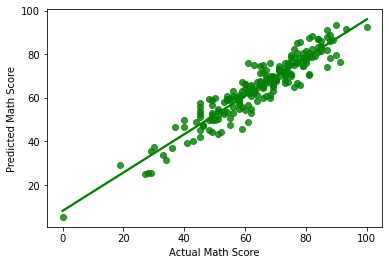

In [186]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,4))
sns.regplot(x=y_test,y=y_pred,color='green',ci=None)
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.show()

## Conclusion:

```Lasso being the best model with hyperparameter tuning alpha = 0.1 with score 88.24219424593616.```

```Train-Test-split = 80-20 & random state = 42```